# Variational Autoencoder in TensorFlow
Using a Bernoulli distribution rather than a Gaussian distribution in the generator networ

In [3]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data


np.random.seed(0)
tf.set_random_seed(0)



In [4]:
mnist_data_path = os.path.join(os.path.dirname(os.getcwd()), 'MNIST_DATA')

mnist = input_data.read_data_sets(mnist_data_path, one_hot=True)
n_samples = mnist.train.num_examples

Extracting /home/xiyou/Desktop/remote/MNIST_DATA/train-images-idx3-ubyte.gz
Extracting /home/xiyou/Desktop/remote/MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting /home/xiyou/Desktop/remote/MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting /home/xiyou/Desktop/remote/MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [5]:
def xavier_init(fan_in, fan_out, constant=1):
    """
    Xaiver initialization of network weights
    :param fan_in:
    :param fan_out:
    :param constant:
    :return:
    """
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval=low, maxval=high,
                             dtype=tf.float32)

In [6]:
class VariationalAutoencoder(object):
    """
    Variational AutoEncoder(VAE) with an sklearn-like interface implemented using Tensorflow.
    This implementation uses probabilistic encoders and decoders using Gaussian distributions
    and realized by multi-layer perceptrons.
    The VAE can be learned end-to-end.
    """
    def __init__(self, network_architecture, trainsfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = trainsfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.x = tf.placeholder(tf.float32, [None, network_architecture['n_input']])

        # create autoencoder network
        self._create_network()
        # define loss function based variational upper-bound and corresponding optimizer
        self._create_loss_optimizer()
        # initializing the tensor flow variables
        init = tf.global_variables_initializer()
        # launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        network_weights = self._initialize_weights(**self.network_architecture)
        # use recognition network to determine mean and log variance of Gaussian distribution in latent space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights['weights_recog'],
                                      network_weights['biases_recog'])
        # draw one sample z from gaussian distribution
        n_z = self.network_architecture['n_z']
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)

        # z = mu + sigma * epsilon (reparameterization trick)
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        self.x_reconstr_mean = \
            self._generator_network(network_weights['weights_gener'],
                                    network_weights['biases_gener'])


    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2,
                            n_hidden_gener_1, n_hidden_gener_2,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))
        }
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))
        }
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))
        }
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))
        }
        return all_weights


    def _recognition_network(self, weights, biases):
        # generate probabilistic encoder (recognition network), which maps inputs onto a normal distribution in latent space.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), biases['out_log_sigma'])
        return z_mean, z_log_sigma_sq


    def _generator_network(self, weights, biases):
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        return x_reconstr_mean

    def _create_loss_optimizer(self):
        """
        The loss is composed of two terms:
        1. the reconstruction loss (the negative log probability of the input under the reconstructed Bernoulli distribution
           induced by the decoder int the data space
        :return:
        """
        reconstr_loss = - tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                        + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean), 1)
        """
        2. latent loss, which is defined as KL divergence between the distribution in latent space induced by the encoder on
            the data and some prior. This acts as a kind of regularizer.
        """
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq),
                                           1)
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """
        Train model based on mini-batch of input data.
        return cost of mini-batch.
        :param X:
        :return:
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """
        Transform data by mapping it into the latent space
        :param X:
        :return:
        """
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """
        Generate data by sampling from latent space.
        if z_mu is None, data for this point in latent space is generated.
        Otherwise z_mu is drawn from prior in latent space.
        :param z_mu:
        :return:
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture['n_z'])
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """
        Use VAE to reconstruct given data
        :param X:
        :return:
        """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})

## We can now define a simple fuction which trains the VAE using mini-batches

In [22]:
def train(network_architecture, learning_rate=0.001,
          batch_size=100, training_epochs=10, display_step=5):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in tqdm(range(training_epochs)):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    return vae

# Illustrating reconstruction quality

Now train a VAE on MNIST by just specifying the network topology. We start with training a VAE with a 20-dimensional latent space.

In [14]:

network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Based on this we can sample some test inputs and visualize how well the VAE can reconstruct those. In general the VAE does really well.

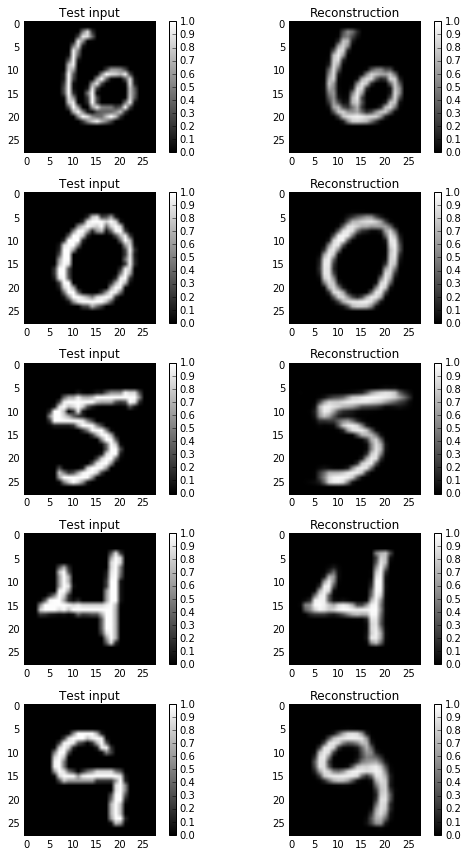

In [15]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

# Illustrating latent space

we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [23]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

  1%|▏         | 1/75 [00:00<01:12,  1.01it/s]

('Epoch:', '0001', 'cost=', '189.889950589')


  8%|▊         | 6/75 [00:05<01:04,  1.07it/s]

('Epoch:', '0006', 'cost=', '154.509866333')


 15%|█▍        | 11/75 [00:10<01:01,  1.04it/s]

('Epoch:', '0011', 'cost=', '150.153914906')


 21%|██▏       | 16/75 [00:15<00:54,  1.07it/s]

('Epoch:', '0016', 'cost=', '147.791772738')


 28%|██▊       | 21/75 [00:19<00:49,  1.08it/s]

('Epoch:', '0021', 'cost=', '145.824116821')


 35%|███▍      | 26/75 [00:24<00:45,  1.08it/s]

('Epoch:', '0026', 'cost=', '144.393987482')


 41%|████▏     | 31/75 [00:29<00:40,  1.08it/s]

('Epoch:', '0031', 'cost=', '143.412306019')


 48%|████▊     | 36/75 [00:33<00:36,  1.07it/s]

('Epoch:', '0036', 'cost=', '142.528070665')


 55%|█████▍    | 41/75 [00:38<00:31,  1.08it/s]

('Epoch:', '0041', 'cost=', '141.805806080')


 61%|██████▏   | 46/75 [00:42<00:26,  1.08it/s]

('Epoch:', '0046', 'cost=', '141.149236284')


 68%|██████▊   | 51/75 [00:47<00:22,  1.08it/s]

('Epoch:', '0051', 'cost=', '140.714772436')


 75%|███████▍  | 56/75 [00:52<00:17,  1.08it/s]

('Epoch:', '0056', 'cost=', '140.179077981')


 81%|████████▏ | 61/75 [00:56<00:12,  1.08it/s]

('Epoch:', '0061', 'cost=', '139.785736181')


 88%|████████▊ | 66/75 [01:01<00:08,  1.08it/s]

('Epoch:', '0066', 'cost=', '139.380970001')


 95%|█████████▍| 71/75 [01:06<00:03,  1.08it/s]

('Epoch:', '0071', 'cost=', '139.013536599')


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


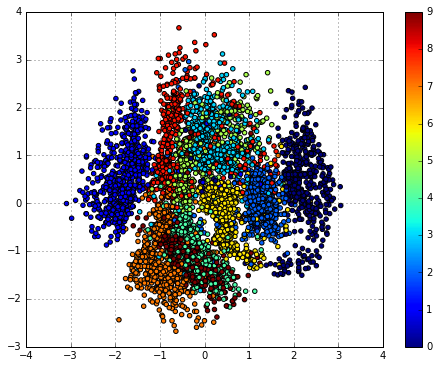

In [24]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated

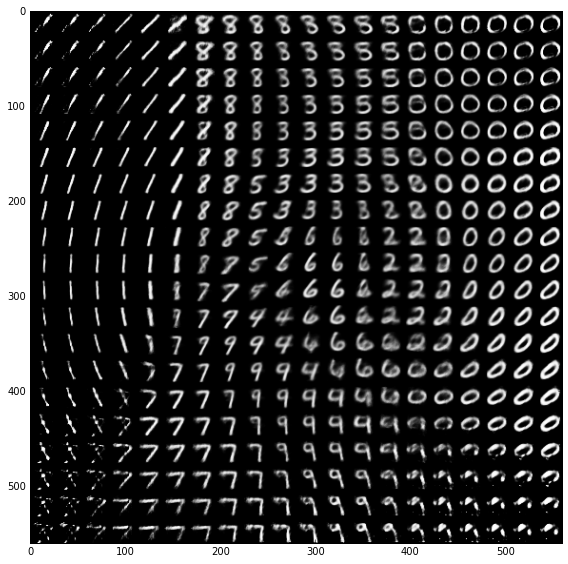

In [25]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()